In [ ]:
Title

I. Introduction

Background:

Question: Can a player’s session frequency and average session length predict whether they subscribe to the newsletter?

Data description: 

II. Method and results 
Description:

In [49]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2) 
library(GGally)

In [43]:
#Load datasets
players <- read_csv("Data/players-2.csv")
sessions <- read_csv("Data/sessions-2.csv")
head(players)
head(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe
1 Pro         TRUE    
2 Veteran     TRUE    
3 Veteran    FALSE    
4 Amateur     TRUE    
5 Regular     TRUE    
6 Amateur     TRUE    
  hashedEmail                                                      played_hours
1 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
2 f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9  3.8        
3 b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28  0.0        
4 23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5  0.7        
5 7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e  0.1        
6 f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977  0.0        
  name      gender Age
1 Morgan    Male    9 
2 Christian Male   17 
3 Blake     Male   17 
4 Flora     Female 21 
5 Kylie     Male   21 
6 Adrian    Female 17

hashedEmail                                                     
1 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
2 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
3 f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
4 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
5 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
6 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
  start_time       end_time         original_start_time original_end_time
1 30/06/2024 18:12 30/06/2024 18:24 1.71977e+12         1.71977e+12      
2 17/06/2024 23:33 17/06/2024 23:46 1.71867e+12         1.71867e+12      
3 25/07/2024 17:34 25/07/2024 17:57 1.72193e+12         1.72193e+12      
4 25/07/2024 03:22 25/07/2024 03:58 1.72188e+12         1.72188e+12      
5 25/05/2024 16:01 25/05/2024 16:12 1.71665e+12         1.71665e+12      
6 23/06/2024 15:08 23/06/2024 17:10 1.71916e+12         1.71916e+12

In [36]:
#Wrangle and clean data
session_info_clean <- sessions |>
  mutate(
    start_time = dmy_hm(start_time, tz = "UTC"),
    end_time = dmy_hm(end_time, tz = "UTC"),
    session_length = as.numeric(difftime(end_time, start_time, units = "mins"))) |>
  filter(session_length > 0)

session_summary <- session_info_clean |>
  group_by(hashedEmail) |>
  summarise(total_sessions = n(),
    avg_session_length = mean(session_length, na.rm = TRUE),
    total_playtime_mins = sum(session_length, na.rm = TRUE),
    .groups = "drop")

merged_df <- players |>
  left_join(session_summary, by = "hashedEmail") |>
  mutate(subscribe = factor(subscribe),
    gender = factor(gender),
    experience = factor(experience)) |>
  drop_na(subscribe, total_sessions, avg_session_length)

merged_df |>
  summarise(
    mean_sessions   = mean(total_sessions),
    med_sessions    = median(total_sessions),
    mean_length     = mean(avg_session_length),
    med_length      = median(avg_session_length),
    pct_subscribed  = mean(as.integer(subscribe) == 2))

merged_df |>
  count(subscribe) |>
  mutate(pct = n / sum(n))

df_knn <- merged_df |>
  select(total_sessions, avg_session_length, subscribe)


mean_sessions med_sessions mean_length med_length pct_subscribed
1 12.264        1            32.51137    18.5       0.744

subscribe n  pct  
1 FALSE     32 0.256
2 TRUE      93 0.744

- Median player only had 1 session, but a small group played >100 times.  
- Average session length is ~50 min, with wide variation (3 – 259 min).  
- ~73 % of players subscribed.

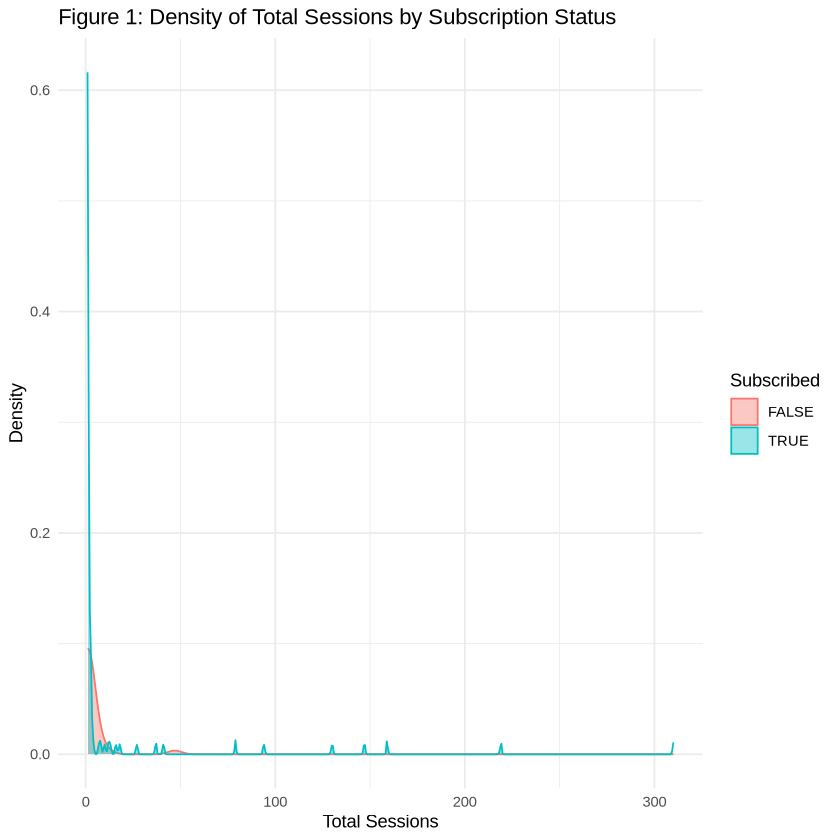

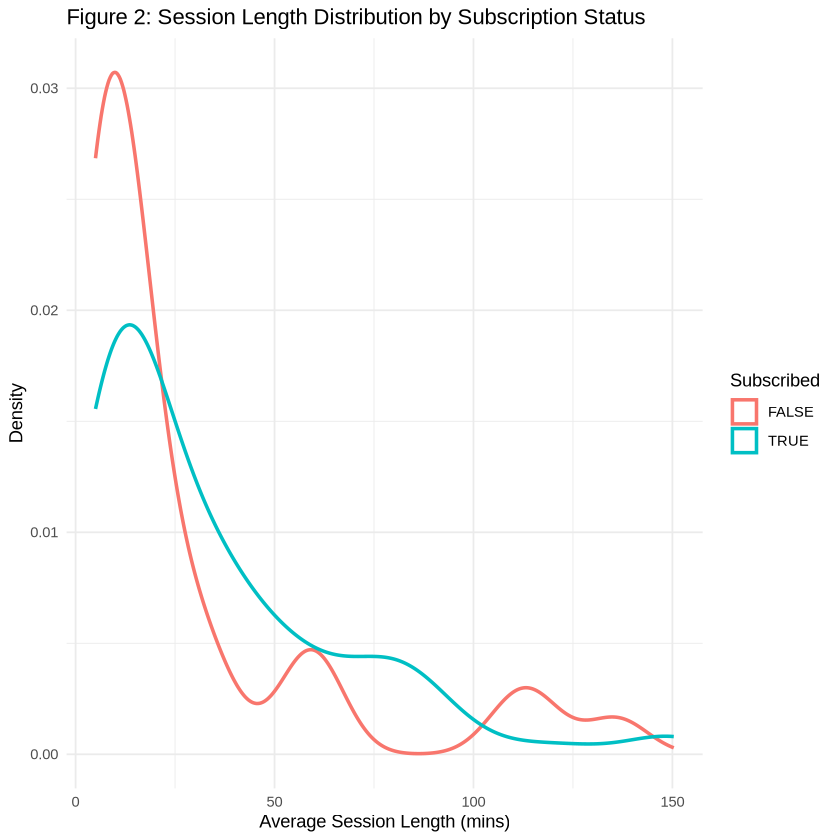

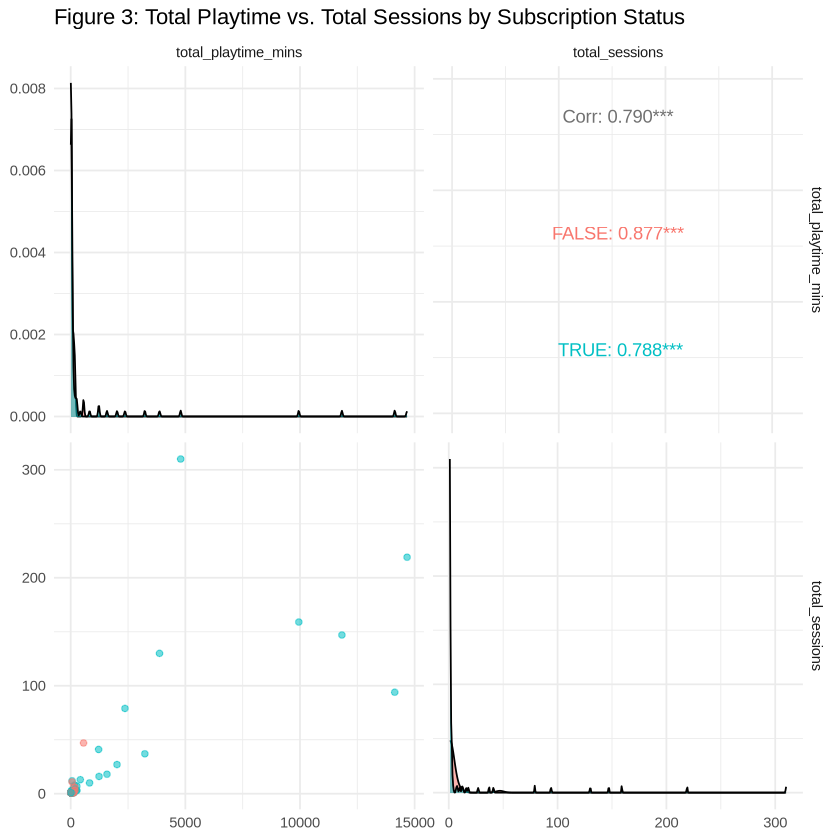

In [55]:
# Exploratory Visualizations
ggplot(merged_df, aes(x = total_sessions, color = subscribe, fill = subscribe)) +
  geom_density(alpha = 0.4) +
  labs(title = "Figure 1: Density of Total Sessions by Subscription Status",
    x = "Total Sessions",
    y = "Density",
    color = "Subscribed",
    fill = "Subscribed") +
  theme_minimal()

ggplot(merged_df, aes(x = avg_session_length, color = subscribe)) +
  geom_density(linewidth = 1) +
  labs(
    title = "Figure 2: Session Length Distribution by Subscription Status",
    x     = "Average Session Length (mins)",
    y     = "Density",
    color = "Subscribed") +
  theme_minimal()

pair_df <- merged_df |>
  select(total_playtime_mins, total_sessions, subscribe) |>
  drop_na()
ggpairs(pair_df,columns = 1:2, mapping = aes(color = subscribe, alpha = 0.6)) +
  labs(title = "Figure 3: Total Playtime vs. Total Sessions by Subscription Status")+
   theme_minimal()

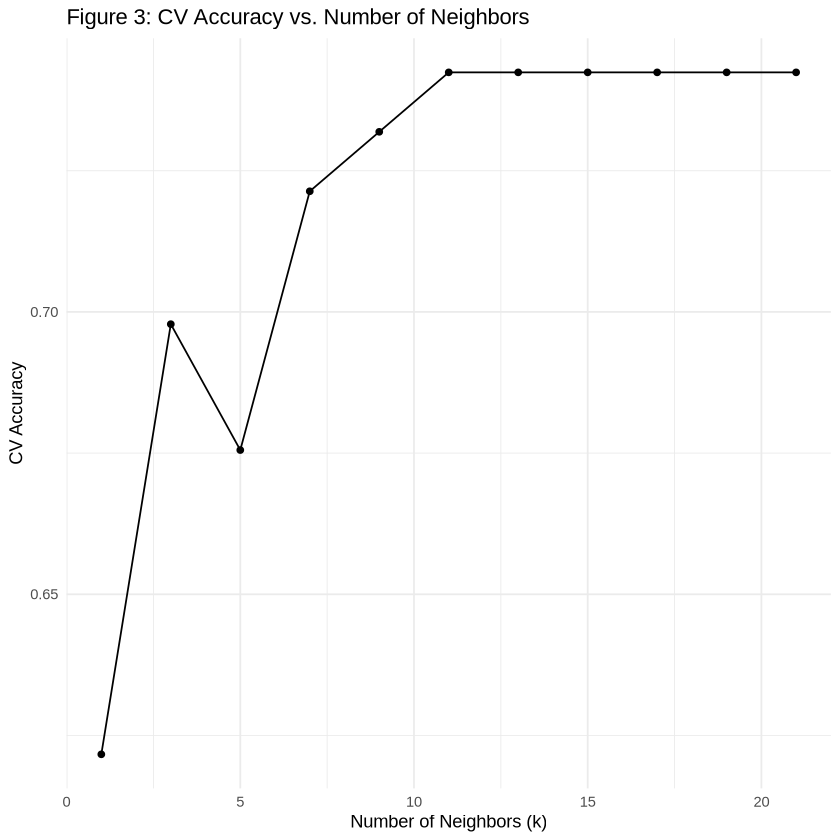

In [58]:
#Data summary
set.seed(123)
data_split <- initial_split(df_knn, prop = 0.75, strata = subscribe)
train_data  <- training(data_split)
test_data   <- testing(data_split)

knn_recipe <- recipe(subscribe ~ total_sessions + avg_session_length, data = train_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

cv_folds <- vfold_cv(train_data, v = 5, strata = subscribe)

knn_tune_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors   = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_tune_wf <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_tune_spec)

knn_grid <- tibble(neighbors = seq(1, 21, by = 2))

tune_results <- knn_tune_wf |>
  tune_grid(resamples = cv_folds,grid = knn_grid,)

best_k <- tune_results |>
  select_best("accuracy")

tune_results |>
  collect_metrics() |>
  filter(.metric == "accuracy") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Figure 3: CV Accuracy vs. Number of Neighbors",
    x     = "Number of Neighbors (k)",
    y     = "CV Accuracy"
  ) +
  theme_minimal()


- Subscribers tend to have more sessions.  
- Session‐length distributions overlap heavily, but subscribers show a slightly heavier right tail.

# A tibble: 2 × 4
  .metric  .estimator .estimate .config             
  <chr>    <chr>          <dbl> <chr>               
1 accuracy binary         0.719 Preprocessor1_Model1
2 roc_auc  binary         0.562 Preprocessor1_Model1


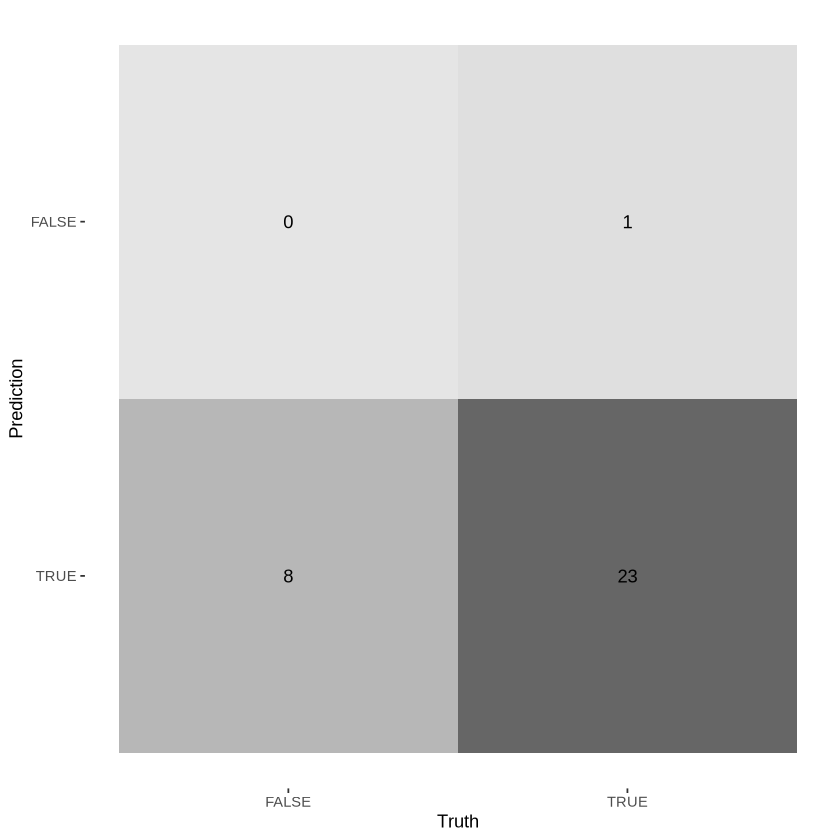

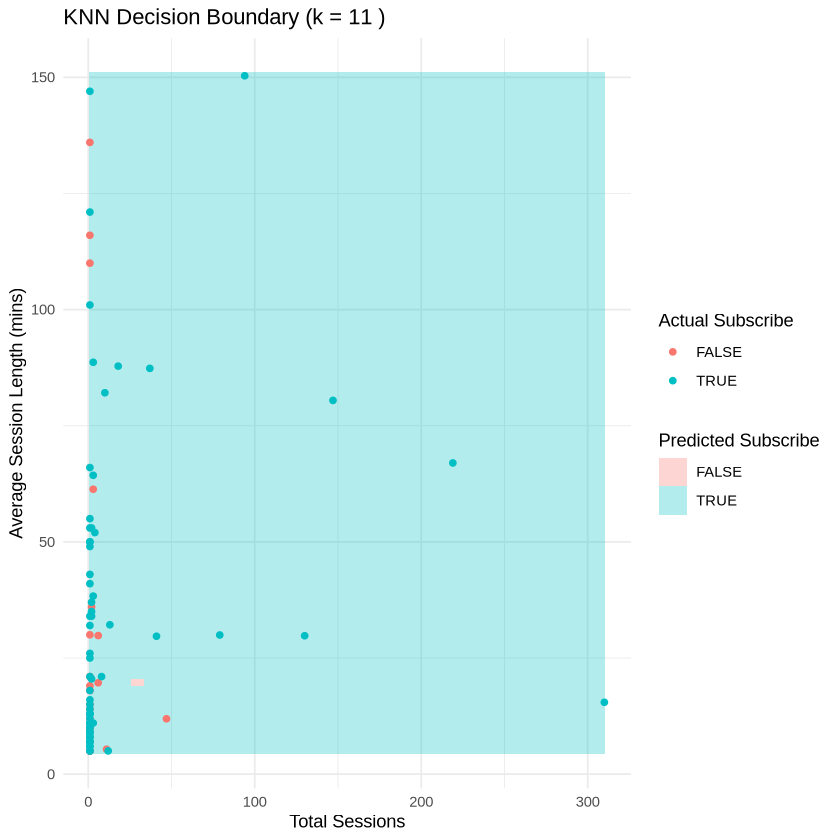

In [59]:
final_wf <- knn_tune_wf |>
  finalize_workflow(best_k)

last_fit_res <- final_wf |>
  last_fit(data_split)

last_fit_res |> collect_metrics() |> print()

preds <- last_fit_res |> collect_predictions()

preds |>
  conf_mat(truth = subscribe, estimate = .pred_class) |>
  autoplot(type = "heatmap")

ggplot() +
  geom_tile(
    data  = grid_pred,
    aes(x = total_sessions, y = avg_session_length, fill = .pred_class),
    alpha = 0.3) +
  geom_point(data = train_data,
             aes(x = total_sessions, y = avg_session_length, color = subscribe),
             size = 1.5) +
  labs( x = "Total Sessions",
        y = "Average Session Length (mins)",
     fill = "Predicted Subscribe",
    color = "Actual Subscribe",
    title = paste("KNN Decision Boundary (k =", best_k$neighbors, ")")) +
  theme_minimal()


Chose KNN because our problem is binary and low‐dimensional,making a distance‐based classifier interpretable. 
Tuned `k` (odd values 1–21) via 5-fold CV, selecting the value with highest accuracy.


Why
- Non-parametric and easy to interpret in 2D.  
- Distance metric aligns with session behavior.

assuming  
- Predictors standardized, no further distributional assumptions.  
- Observations independent.

limitation
- Sensitive to outliers and scaling.  
- Doesn’t capture interactions beyond Euclidean distance.  

data split
- 75/25 stratified train/test split.  
- 5-fold CV on training set to tune `k`.

conclusion
Future work could incorporate time-of-day or in-game actions to improve predictive accuracy.